In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
# !pip3 install ipympl
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

In [2]:
root = "FullDataSet_PD-BioStampRC21"
o_df = pd.read_csv("Clinic_DataPDBioStampRCStudy.csv")

In [3]:
o_df

,ID,Sex,Status,Age,updrs_3_17a,updrs_3_17b,updrs_3_17c,updrs_3_17d,updrs_3_17e,updrs_3_17a_off,updrs_3_17b_off,updrs_3_17c_off,updrs_3_17d_off,updrs_3_17e_off,updrs_3_17a_on,updrs_3_17b_on,updrs_3_17c_on,updrs_3_17d_on,updrs_3_17e_on
0,5,Female,Control,74,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,Male,PD,73,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
2,7,Female,Control,52,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,Female,Control,77,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,Female,PD,72,NaN,NaN,NaN,NaN,NaN,3.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
5,12,Female,PD,64,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,13,Female,PD,60,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,14,Female,Control,56,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,15,Male,PD,65,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
9,16,Female,Control,62,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
control_ids = ["005", "007", "008", "014", "016", "018", "020", "022", "027", "030", "039", "041", "043", "045", "058", "060", "062"]
pd_ids = ["006", "010", "012", "013", "015", "017", "023", "024", "025", "033", "035", "036", "038", "040", "042", "044", "063"]
pd_ids_with_ONOFF = ["006", "010", "012", "013", "015", "017", "025", "033", "040", "042", "044", "063"]
pd_df_files = [root + "/" + id + "/lh_ID" + id + "Accel.csv" for id in pd_ids_with_ONOFF]
pd_annot_files = [root + "/" + id + "/AnnotID" + id + ".csv" for id in pd_ids_with_ONOFF]
# control_df_files = [root + "/" + id + "/lh_ID" + id + "Accel.csv" for id in control_ids]
# control_annot_files = [root + "/" + id + "/AnnotID" + id + ".csv" for id in control_ids]
# files = ["006/lh_ID006Accel.csv", "006/AnnotID006.csv", "005/lh_ID005Accel.csv", "005/AnnotID005.csv"]

In [5]:
SAMPLE_RATE = 31.25 # samples per second
DURATION = 60 # in seconds
GROUP_SIZE = int(DURATION * SAMPLE_RATE)
WINDOW_SIZE_IN_S = 5 # in seconds
WINDOW_SIZE = int(WINDOW_SIZE_IN_S * SAMPLE_RATE)

def z_score_normalize(df):
    return (df - df.mean())/df.std()

def create_segments(df, group_size, sliding_window):
    
    segments = []
    for i in range(0, len(df) - group_size, sliding_window):
        # Normalize each group
        xs = z_score_normalize(df['Accel X (g)'].values[i: i + group_size])
        ys = z_score_normalize(df['Accel Y (g)'].values[i: i + group_size])
        zs = z_score_normalize(df['Accel Z (g)'].values[i: i + group_size])
        
        segments.append([xs, ys, zs])

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, group_size, 3) # Faster

    return reshaped_segments

# Load and preprocess data without data aggregates

X_ON = np.empty(shape=[0, GROUP_SIZE, 3])
X_OFF = np.empty(shape=[0, GROUP_SIZE, 3])

for i in range(len(pd_df_files)):
    file = pd_df_files[i]
    annot = pd_annot_files[i]
    df = pd.read_csv(file)
    annot_df = pd.read_csv(annot, na_values="")
    
    # Handle ON data
    on_annot_data = annot_df[annot_df["Value"] == "ON"]
    on_data = df[(df["Timestamp (ms)"] >= on_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= on_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
    on_segments = create_segments(on_data, GROUP_SIZE, WINDOW_SIZE)
    
#     X_features = pd.concat([X_features, pd.DataFrame(on_segments, columns=X_features.columns)])
#     Y_labels = pd.concat([Y_labels, pd.Series([True]).repeat(len(on_segments))])
    X_ON = np.append(X_ON, on_segments, axis=0)
    
    # Handle OFF data
    off_annot_data = annot_df[annot_df["Value"] == "OFF"]
    off_data = df[(df["Timestamp (ms)"] >= off_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= off_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
    off_segments = create_segments(off_data, GROUP_SIZE, WINDOW_SIZE)
    
    X_OFF = np.append(X_OFF, off_segments, axis=0)

In [6]:
print(X_ON.shape)
print(X_OFF.shape)
print(X_ON[0, :5])
print(X_OFF[0, :5])

(2825, 1875, 3)
(4538, 1875, 3)
[[0.65408742 0.65620679 0.73886192]
 [0.59262592 0.60110337 0.67528105]
 [0.67316169 0.65408742 0.60746145]
 [0.60322273 0.62017763 0.61805826]
 [0.70919085 0.69011658 0.64560997]]
[[-0.95248383 -0.39996186 -0.19977273]
 [ 0.31271142 -0.82035899 -1.00853682]
 [-0.87240815 -0.38394672 -0.14772356]
 [ 0.22863199 -0.64819634 -0.81635523]
 [-0.88041574 -0.37994292 -0.42798832]]


In [7]:
# Resampling
import random

random.seed(100)
sample_indexes = random.sample(range(len(X_OFF)), len(X_ON))
X_OFF_resampled = np.empty(shape=[0, GROUP_SIZE, 3])
for i in sample_indexes:
    X_OFF_resampled = np.append(X_OFF_resampled, [X_OFF[i]], axis=0)

# Combining ON & OFF
X_resampled = np.empty(shape=[0, GROUP_SIZE, 3])
X_resampled = np.append(X_resampled, X_ON, axis=0)
X_resampled = np.append(X_resampled, X_OFF_resampled, axis=0)

Y_labels = np.empty(shape=[0])
Y_labels = np.append(Y_labels, [True] * len(X_ON), axis=0)
Y_labels = np.append(Y_labels, [False] * len(X_OFF_resampled), axis=0)

print(X_resampled.shape)
print(Y_labels.shape)
unique, counts = np.unique(Y_labels, return_counts=True)
print(dict(zip(unique, counts)))

(5650, 1875, 3)
(5650,)
{0.0: 2825, 1.0: 2825}


In [8]:
# pd_df_list = [pd.read_csv(file) for file in pd_df_files]
# pd_annot_df_list = [pd.read_csv(file,na_values="") for file in pd_annot_files]

# pd_df = pd.concat(pd_df_list)
# pd_annot_df = pd.concat(pd_annot_df_list)

# #     Visualisation of data from each participant and checking sampling rates
    
# plot_cols = ["Accel X (g)", "Accel Y (g)", "Accel Z (g)"]
# plot_features = on_data[plot_cols]
# plot_features.index = on_data["Timestamp (ms)"]
# _ = plot_features.plot(subplots=True)

# plot_features = off_data[plot_cols]
# plot_features.index = off_data["Timestamp (ms)"]
# _ = plot_features.plot(subplots=True)

# timeDiff = on_data["Timestamp (ms)"].diff()
# print(timeDiff.unique())

# timeDiff = off_data["Timestamp (ms)"].diff()
# print(timeDiff.unique())

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# data = X_features.reshape(13233*90, 3)
# fig = plt.figure()

# plt.boxplot(data)
# plt.show()

# plt.violinplot(data)
# plt.show()

# fig = plt.figure()

# plt.hist(data)
# plt.show()

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

nBatch = 32

X_resampled = X_resampled.reshape(len(X_resampled), 3, GROUP_SIZE, 1)

train_x, test_x, train_y, test_y = train_test_split(X_resampled, Y_labels, test_size = 0.2, random_state = 7)
# train_val_x, test_x, train_val_y, test_y = train_test_split(X_resampled, Y_labels, test_size = 0.2, random_state = 7)

# train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size = 0.25, random_state = 7)

train_x = torch.Tensor(train_x)
train_y = F.one_hot(torch.tensor(train_y).to(torch.int64), 2).to(torch.float32)

# val_x = torch.Tensor(val_x)
# val_y = F.one_hot(torch.tensor(val_y).to(torch.int64), 2).to(torch.float32)

test_x = torch.Tensor(test_x)
test_y = F.one_hot(torch.tensor(test_y).to(torch.int64), 2).to(torch.float32)

train_dataset = TensorDataset(train_x, train_y)
# val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=nBatch, drop_last=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=nBatch, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=nBatch, drop_last=True)

In [11]:
print(train_x.shape)
print(train_y.shape)
# print(val_x.shape)
# print(val_y.shape)
print(test_x.shape)
print(test_y.shape)
for inp, label in train_dataset:
    print('{}:{}'.format(inp.shape, label.shape))
    break
for inp, label in test_dataset:
    print('{}:{}'.format(inp.shape, label.shape))
    break
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    print(images[0, :, :5])
    print(labels[0, :5])
    break
for i, (images, labels) in enumerate(test_loader):
    print(images.shape)
    print(labels.shape)
    print(images[0, :, :5])
    print(labels[0, :5])
    break

torch.Size([4520, 3, 1875, 1])
torch.Size([4520, 2])
torch.Size([1130, 3, 1875, 1])
torch.Size([1130, 2])
torch.Size([3, 1875, 1]):torch.Size([2])
torch.Size([3, 1875, 1]):torch.Size([2])
torch.Size([32, 3, 1875, 1])
torch.Size([32, 2])
tensor([[[-0.5993],
         [-0.6211],
         [-0.6065],
         [-0.6260],
         [-0.6551]],

        [[-0.8276],
         [-1.0833],
         [-0.8276],
         [-0.8545],
         [-0.4103]],

        [[ 0.7111],
         [ 0.5224],
         [ 0.4861],
         [ 0.5877],
         [ 0.8127]]])
tensor([0., 1.])
torch.Size([32, 3, 1875, 1])
torch.Size([32, 2])
tensor([[[-0.4418],
         [-0.3482],
         [-0.3450],
         [-0.3972],
         [-0.4287]],

        [[ 0.2968],
         [ 0.4529],
         [ 0.5860],
         [ 0.3429],
         [ 0.3173]],

        [[ 0.7865],
         [ 1.1709],
         [ 1.2523],
         [ 1.1481],
         [ 0.9852]]])
tensor([0., 1.])


In [16]:
import torch.nn as nn
import torch.optim as optim

class Grouped2DCNN(nn.Module):
    def __init__(self):
        super(Grouped2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 1), stride=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 1), stride=(2, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5, 1), stride=(2, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(5, 1))
        self.dropout1 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(in_features=1472, out_features=32)
        self.dropout2 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(in_features=32, out_features=2)
    def forward(self, x):
#         print(x.shape) # torch.Size([32, 3, 1875, 1])
        x = self.conv1(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 32, 936, 1])
        x = self.conv2(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 64, 466, 1])
        x = self.conv3(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 32, 231, 1])
        x = self.maxpool1(x)
        x = self.dropout1(x)
#         print(x.shape) # torch.Size([32, 32, 46, 1])
        x = torch.flatten(x, 1)
#         print(x.shape) # torch.Size([32, 1472])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
#         print(x.shape) # torch.Size([32, 32])
        output = self.fc2(x)
#         print(output.shape) # torch.Size([32, 2])
        return output

model = Grouped2DCNN()

In [17]:
model = Grouped2DCNN()

lr = 0.001
betas = (0.9, 0.999)
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=lr, betas=betas)

model.to(device)

minValidLoss = np.inf
        
for e in range(0, num_epochs):
	model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	trainCorrect = 0
	valCorrect = 0
	for x, y in train_loader:
		(x, y) = (x.to(device), y.to(torch.float32).to(device))
		# print(model)
		pred = model(x)
		loss = criterion(pred, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		totalTrainLoss += loss

# 	model.eval()
# 	for x, y in val_loader:
# 		target = model(x)
# 		loss = criterion(target,y)
# 		totalValLoss += loss

# 	print(f'Epoch {e} \t\t Training Loss: {totalTrainLoss.item()} \t\t Validation Loss: {totalValLoss.item()}')
	print(f'Epoch {e} \t\t Training Loss: {totalTrainLoss.item()}')
     
# 	if minValidLoss > totalValLoss:
# 		print(f'Validation Loss Decreased({minValidLoss:.6f}--->{totalValLoss:.6f}) \t Saving The Model')
# 		minValidLoss = totalValLoss
# 		torch.save({
#                     'epoch': e,
#                     'state_dict': model.state_dict(),
#                     'totalTrainLoss': totalTrainLoss,
#                     'totalValLoss': totalValLoss,
#                     'optimizer' : optimizer.state_dict()
#                     }, 'best_G180_window_1conv_2dcnn_imu_onoff_model.pth')

print(f'Saving Final Model')
torch.save({
            'epoch': e,
            'state_dict': model.state_dict(),
            'totalTrainLoss': totalTrainLoss,
            'totalValLoss': totalValLoss,
            'optimizer' : optimizer.state_dict()
            }, 'final_G180_window_noval_3conv_6_8DO_2stride_2dcnn_imu_onoff_model.pth')

Epoch 0 		 Training Loss: 98.07872772216797
Epoch 1 		 Training Loss: 97.83162689208984
Epoch 2 		 Training Loss: 97.75088500976562
Epoch 3 		 Training Loss: 97.74658203125
Epoch 4 		 Training Loss: 97.38311767578125
Epoch 5 		 Training Loss: 96.73680877685547
Epoch 6 		 Training Loss: 96.07328796386719
Epoch 7 		 Training Loss: 94.7410659790039
Epoch 8 		 Training Loss: 93.54754638671875
Epoch 9 		 Training Loss: 91.14854431152344
Epoch 10 		 Training Loss: 87.61241149902344
Epoch 11 		 Training Loss: 84.89168548583984
Epoch 12 		 Training Loss: 81.07989501953125
Epoch 13 		 Training Loss: 76.60395050048828
Epoch 14 		 Training Loss: 74.19227600097656
Epoch 15 		 Training Loss: 69.21930694580078
Epoch 16 		 Training Loss: 63.53291320800781
Epoch 17 		 Training Loss: 59.54421615600586
Epoch 18 		 Training Loss: 55.111942291259766
Epoch 19 		 Training Loss: 54.71868133544922
Epoch 20 		 Training Loss: 49.45280838012695
Epoch 21 		 Training Loss: 45.95482635498047
Epoch 22 		 Training Lo

Train Loss: 0.008782

Train Accuracy of     0: 100% (2269/2269)
Train Accuracy of     1: 99% (2230/2243)

Train Accuracy (Overall): 99% (4499/4512)


<IPython.core.display.Javascript object>


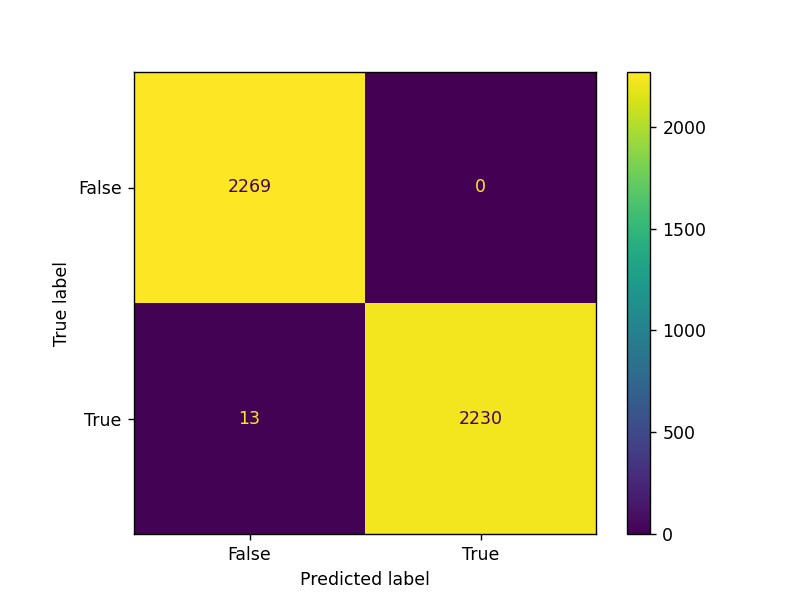

{'Accuracy': 0.9971187943262412, 'Precision': 1.0, 'Sensitivity_recall': 0.9942041908158716, 'Specificity': 1.0, 'F1_score': 0.9970936731500112}


In [18]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 2

train_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(train_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	train_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(NUM_CLASSES):
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
        i, 100.0 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


Test Loss: 0.124503

Test Accuracy of     0: 98% (541/550)
Test Accuracy of     1: 96% (552/570)

Test Accuracy (Overall): 97% (1093/1120)


<IPython.core.display.Javascript object>


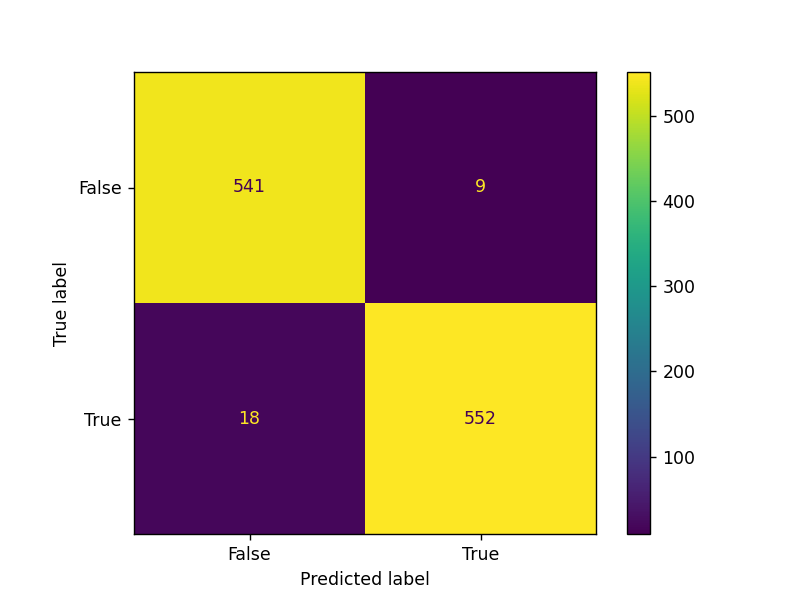

{'Accuracy': 0.9758928571428571, 'Precision': 0.983957219251337, 'Sensitivity_recall': 0.968421052631579, 'Specificity': 0.9836363636363636, 'F1_score': 0.9761273209549072}


In [19]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

test_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []
model.eval()

for i, (x, y) in enumerate(test_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	test_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


# Prediction using model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np

class Grouped2DCNN(nn.Module):
    def __init__(self):
        super(Grouped2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 1), stride=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 1), stride=(2, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(5, 1), stride=(2, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(5, 1))
        self.dropout1 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(in_features=1472, out_features=32)
        self.dropout2 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(in_features=32, out_features=2)
    def forward(self, x):
#         print(x.shape) # torch.Size([32, 3, 1875, 1])
        x = self.conv1(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 32, 936, 1])
        x = self.conv2(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 64, 466, 1])
        x = self.conv3(x)
        x = F.relu(x)
#         print(x.shape) # torch.Size([32, 32, 231, 1])
        x = self.maxpool1(x)
        x = self.dropout1(x)
#         print(x.shape) # torch.Size([32, 32, 46, 1])
        x = torch.flatten(x, 1)
#         print(x.shape) # torch.Size([32, 1472])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
#         print(x.shape) # torch.Size([32, 32])
        output = self.fc2(x)
#         print(output.shape) # torch.Size([32, 2])
        return output

model = Grouped2DCNN()

lr = 0.001
betas = (0.9, 0.999)
model = Grouped2DCNN()
optimizer = optim.NAdam(model.parameters(), lr=lr, betas=betas)

file_path = './BESTfinal_G180_window_noval_3conv_6_8DO_2stride_2dcnn_imu_onoff_model.pth'

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

Grouped2DCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 1), stride=(2, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 1), stride=(2, 1))
  (conv3): Conv2d(64, 32, kernel_size=(5, 1), stride=(2, 1))
  (maxpool1): MaxPool2d(kernel_size=(5, 1), stride=(5, 1), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc1): Linear(in_features=1472, out_features=32, bias=True)
  (dropout2): Dropout(p=0.8, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [127]:
def z_score_normalize(df):
    return (df - df.mean())/df.std()

SAMPLE_RATE = 31.25 # samples per second
DURATION = 60 # in seconds
GROUP_SIZE = int(DURATION * SAMPLE_RATE)
print(GROUP_SIZE)

range_rand = 1.0
input = [[random.uniform(-range_rand, range_rand) for i in range(3)] for j in range(GROUP_SIZE)]
input = z_score_normalize(pd.DataFrame(input)).values.tolist()
input = np.reshape(input, (1, 3, GROUP_SIZE, 1))
input = torch.FloatTensor(input)
print(input.shape)

output = model(input)
print(output.shape)
print(torch.max(output.data, 1)[1])
prediction = int(np.argmax(np.bincount(torch.max(output.data, 1)[1]))) 
print("OFF") if prediction == 0 else print("ON")


1875
torch.Size([1, 3, 1875, 1])
torch.Size([1, 2])
tensor([0])
OFF


# Data Visualization

<IPython.core.display.Javascript object>


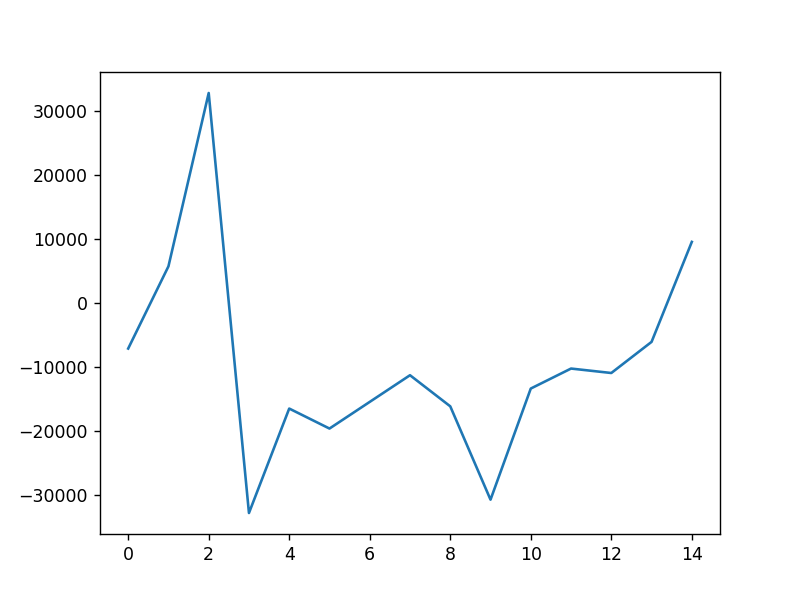

In [6]:
from scipy.fft import fft, fftfreq
from sklearn import preprocessing

SAMPLE_RATE = 3

file = pd_df_files[0]
annot = pd_annot_files[0]
df = pd.read_csv(file)
annot_df = pd.read_csv(annot, na_values="")
on_annot_data = annot_df[annot_df["Value"] == "ON"]
on_data = df[(df["Timestamp (ms)"] >= on_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= on_annot_data.iloc[-1]["Stop Timestamp (ms)"])]

# Getting data aggregates
N = 15
on_lst = [on_data.iloc[i:i + N] for i in range(0, len(on_data), N)]

on_dat = on_lst[0]

x_on = on_dat["Accel Z (g)"]

scaler = preprocessing.MinMaxScaler(feature_range=(-32767 , 32767))

normalized_data = scaler.fit_transform(x_on.values.reshape(-1, 1))

plt.close()
plt.plot(normalized_data)
plt.show()

<IPython.core.display.Javascript object>


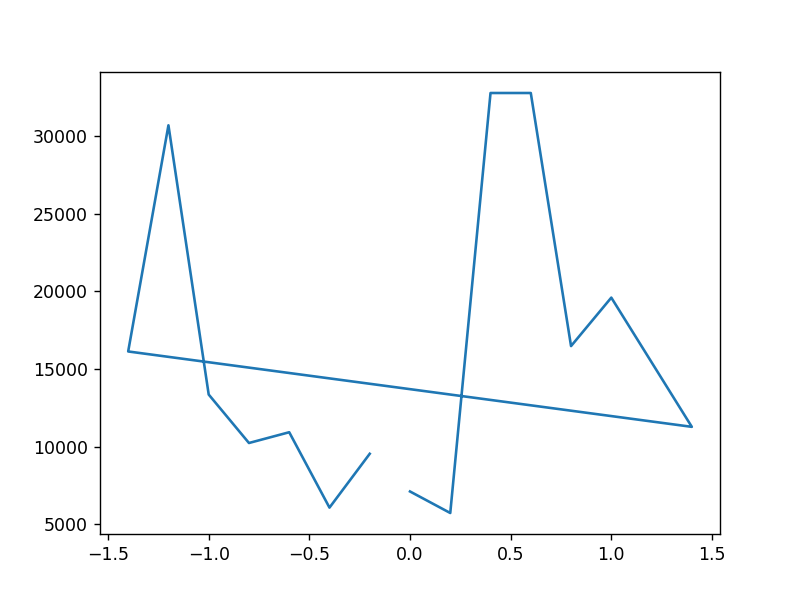

In [10]:
yf = fft(normalized_on_data)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.close()
plt.plot(xf, np.abs(yf))
plt.show()

In [ ]:
# pd_on_df = pd.DataFrame()
# pd_off_df = pd.DataFrame()
# for i in range(len(pd_df_files)):
#     file = pd_df_files[i]
#     annot = pd_annot_files[i]
#     df = pd.read_csv(file)
#     annot_df = pd.read_csv(annot, na_values="")
#     on_annot_data = annot_df[annot_df["Value"] == "ON"]
#     on_data = df[(df["Timestamp (ms)"] >= on_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= on_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
#     pd_on_df = pd.concat([pd_on_df, on_data])
    
#     off_annot_data = annot_df[annot_df["Value"] == "OFF"]
#     off_data = df[(df["Timestamp (ms)"] >= off_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= off_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
#     pd_off_df = pd.concat([pd_off_df, off_data])

<IPython.core.display.Javascript object>


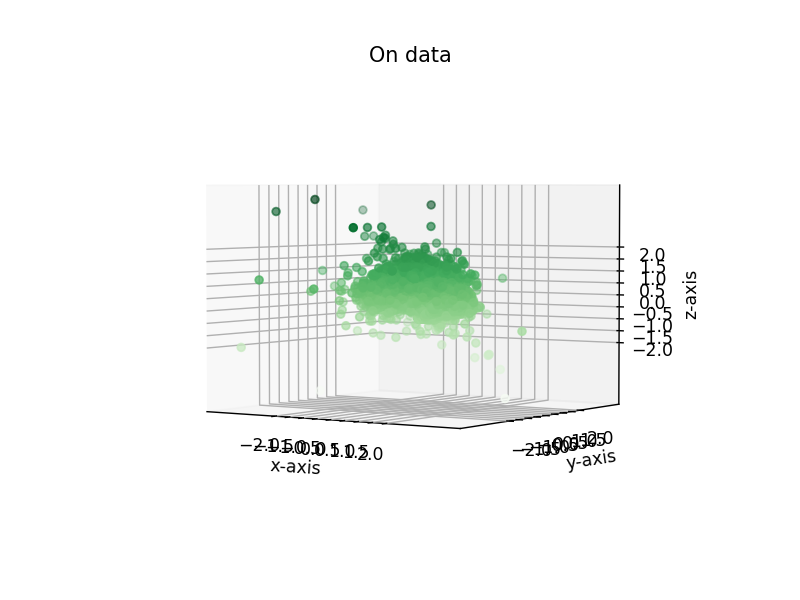

In [72]:
# %matplotlib notebook
fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
ax = plt.axes(projection="3d")
xdata = pd_on_df.iloc[:,1]
ydata = pd_on_df.iloc[:,2]
zdata = pd_on_df.iloc[:,3]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.set_title("On data")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_zticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])

<IPython.core.display.Javascript object>


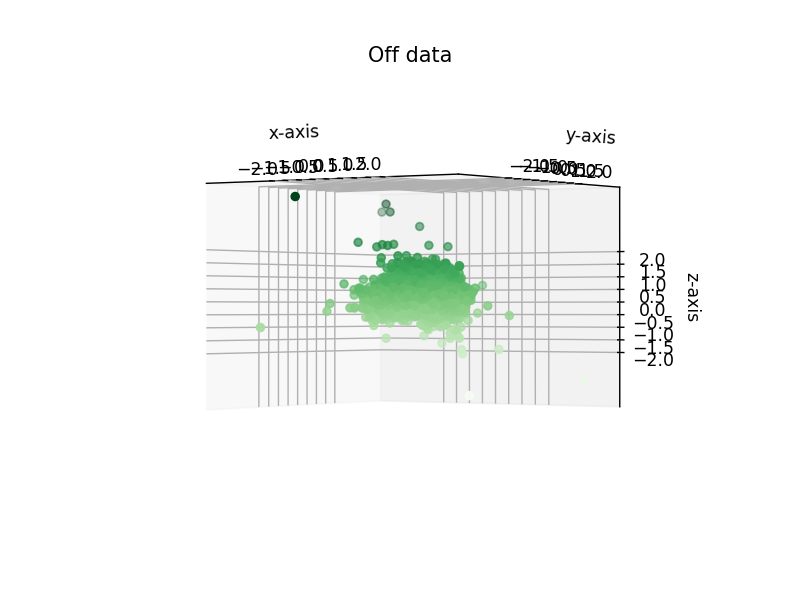

In [73]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
ax = plt.axes(projection="3d")
xdata = pd_off_df.iloc[:,1]
ydata = pd_off_df.iloc[:,2]
zdata = pd_off_df.iloc[:,3]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.set_title("Off data")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_zticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])

## UNUSED

In [5]:
# from sklearn import preprocessing

# def normalize(data):
#     scaler = preprocessing.MinMaxScaler(feature_range=(-32767 , 32767))
#     normalized_data = scaler.fit_transform(data.values.reshape(-1, 1))
#     return normalized_data

# from scipy.fft import fft, fftfreq

# def extract_peak_frequency(data, sample_rate):
#     fft_data = fft(data)
#     freqs = fftfreq(len(data), 1 / sample_rate)

#     peak_coefficient = np.argmax(np.abs(fft_data))
#     peak_freq = freqs[peak_coefficient]

#     return abs(peak_freq * sample_rate)

# # Load and preprocess data with data aggregates

# SAMPLE_RATE = 3
# N = 15

# X_features = pd.DataFrame(columns=['X_Peak_Freq','Y_Peak_Freq','Z_Peak_Freq'])
# Y_labels = []

# for i in range(len(pd_df_files)):
#     file = pd_df_files[i]
#     annot = pd_annot_files[i]
#     df = pd.read_csv(file)
#     annot_df = pd.read_csv(annot, na_values="")
    
#     # Handle ON data
#     on_annot_data = annot_df[annot_df["Value"] == "ON"]
#     on_data = df[(df["Timestamp (ms)"] >= on_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= on_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
#     # Getting data aggregates
#     on_lst = [on_data.iloc[i:i + N] for i in range(0, len(on_data), N)]
    
#     for group in on_lst:
#         peak_freqs = []
#         for axis in ["Accel X (g)", "Accel Y (g)", "Accel Z (g)"]:
#             raw_data = group[axis]
#             normalized_data = normalize(raw_data)
#             peak_freq = extract_peak_frequency(normalized_data, SAMPLE_RATE)
#             peak_freqs.append(peak_freq)
#         X_features = pd.concat([X_features, pd.DataFrame([peak_freqs], columns=X_features.columns)])
#         Y_labels.append(True)
    
#     # Handle OFF data
#     off_annot_data = annot_df[annot_df["Value"] == "OFF"]
#     off_data = df[(df["Timestamp (ms)"] >= off_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= off_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
#     off_lst = [off_data.iloc[i:i + N] for i in range(0, len(on_data), N)]
    
#     for group in off_lst:
#         peak_freqs = []
#         for axis in ["Accel X (g)", "Accel Y (g)", "Accel Z (g)"]:
#             raw_data = group[axis]
#             normalized_data = normalize(raw_data)
#             peak_freq = extract_peak_frequency(normalized_data, SAMPLE_RATE)
#             peak_freqs.append(peak_freq)
#         X_features = pd.concat([X_features, pd.DataFrame([peak_freqs], columns=X_features.columns)])
#         Y_labels.append(False)

In [23]:
# SAMPLE_RATE = 3
# GROUP_SIZE = 15

# def z_score_normalize(df):
#     return df/df.std()

# def create_segments(df, group_size):
    
#     segments = []
#     for i in range(0, len(df) - group_size, group_size):
#         xs = df['Accel X (g)'].values[i: i + group_size]
#         ys = df['Accel Y (g)'].values[i: i + group_size]
#         zs = df['Accel Z (g)'].values[i: i + group_size]
        
#         segments.append([xs, ys, zs])

#     reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, group_size, 3) # Faster

#     return reshaped_segments

# # Load and preprocess data without data aggregates

# X_features = np.empty(shape=[0, GROUP_SIZE, 3])
# Y_labels = np.empty(shape=[0])

# for i in range(len(pd_df_files)):
#     file = pd_df_files[i]
#     annot = pd_annot_files[i]
#     df = pd.read_csv(file)
#     annot_df = pd.read_csv(annot, na_values="")
    
#     # Handle ON data
#     on_annot_data = annot_df[annot_df["Value"] == "ON"]
#     on_data = df[(df["Timestamp (ms)"] >= on_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= on_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
#     on_segments = create_segments(on_data, GROUP_SIZE)
    
# #     X_features = pd.concat([X_features, pd.DataFrame(on_segments, columns=X_features.columns)])
# #     Y_labels = pd.concat([Y_labels, pd.Series([True]).repeat(len(on_segments))])
#     X_features = np.append(X_features, on_segments, axis=0)
#     Y_labels =  np.append(Y_labels, [True] * len(on_segments), axis=0)
    
#     # Handle OFF data
#     off_annot_data = annot_df[annot_df["Value"] == "OFF"]
#     off_data = df[(df["Timestamp (ms)"] >= off_annot_data.iloc[0]["Start Timestamp (ms)"]) & (df["Timestamp (ms)"] <= off_annot_data.iloc[-1]["Stop Timestamp (ms)"])]
    
#     off_segments = create_segments(off_data, GROUP_SIZE)
    
#     X_features = np.append(X_features, off_segments, axis=0)
#     Y_labels =  np.append(Y_labels, [False] * len(off_segments), axis=0)
    
# X_features = z_score_normalize(X_features)